# Building a neural network from scratch

While powerful libraries remove some of the repetitive work in deep learning, they can hide the important details you need to really understand what's going on under the hood. So in this first example, we won't touch any of the MXNet's more abstract features. Instead we'll rely only on autograd, NDArray, and building everything else from scratch.

First, we'll import a few dependencies:

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

## Linear regression


We'll focus on the problem of linear regression. Given a collection of data points ``X``, and corresponding target values ``y``, we'll try to find the line, parameterized by a vector ``w`` and intercept ``b`` that approximately fits ``y = Xw + b``. 

To make things easy, we're going to work with a synthetic data where we know the solution, by generating random data points ``X[i]`` and labels ``y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise`` where the noise is drawn from a random gaussian with mean ``0`` and variance ``.1``.

In [2]:
X = np.random.randn(10000,2)
Y = 2* X[:,0] - 3.4 * X[:,1] + 4.2 + .01 * np.random.normal(size=10000)


Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value. 

In [3]:
print(X[0])
print(Y[0])

[-0.26270866 -0.08024418]
3.94456126417


We can confirm that for any randomly chosen point, a linear combination with the (known) optimal parameters produces a prediction that is indeed close to the target value

In [4]:
print(2 * X[0,0] - 3.4 * X[0,1] + 4.2)

3.94741287905


We can visualize the correspondence between our second feature (``X[:,1]``) and the target values ``Y`` by generating a scatter plot with the Python plotting package ``matplotlib``.

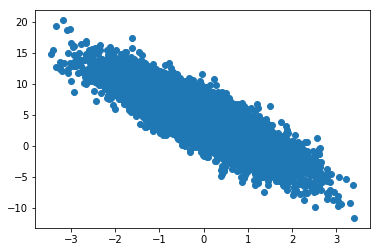

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,1],Y)
plt.show()


## Data iterators

Once we start working with neural networks, we're going to need to iterate through our data points quickly. We'll also want to be able to grab batches of ``k`` data points at a time, to shuffle our data. In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data. In particular, we'll work with the simple  ``NDArrayIter`` class.

In [6]:
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

Once we've initialized our NDArrayIter (``train_data``), we can easily fetch batches by calling ``train_data.next()``. Furthermore ``batch.data`` gives us a list of inputs. Because our model has only one input (``X``), we'll just be grabbing ``batch.data[0]``.

In [7]:
batch = train_data.next()
print(batch.data[0])

[[-0.69365638 -0.46424943]
 [-2.96224928 -0.2978498 ]
 [-0.41190961  0.38970453]
 [-0.17276376  2.26188397]]
<NDArray 4x2 @cpu(0)>


We can also grab the corresponding labels

In [8]:
print(batch.label[0])

[ 4.39895439 -0.71928126  2.04943419 -3.82203984]
<NDArray 4 @cpu(0)>


Finally, we can iterate over ``train_data`` just as through it was an ordinary Python list:

In [9]:
counter = 0
train_data.reset()
for i, batch in enumerate(train_data):
    counter += 1
print(counter)

2500


You might notice that we called ``train_data.reset()`` before iterating through it. This let's the iterator know to reshuffle the data, preparing for the next pass. See what happens if we try to pass over the data again without first hitting ``reset()``.

In [10]:
counter = 0
for i, batch in enumerate(train_data):
    counter += 1
print(counter)

0


## Model parameters

Now let's allocate some memory for our parameters and set their initial values.

In [11]:
w = nd.random_normal(shape=(2,1))
b = nd.random_normal(shape=1)

params = [w, b]

In the succeeding cells, we're going to update these parameters to better fit our data. That will involve taking the gradient (a multi-dimensional derivative) of some *loss function* with respect to the parameters. We'll update each parameter in the direction that reduces the loss. But first, let's just allocate some memory for each gradient.

In [12]:
for param in params:
    param.attach_grad()

## Neural networks

Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible *useful* neural network. To calculate the output of the linear model, we simply multipy a given input with the model's weights (``w``), and add the offset ``b``.

In [13]:
def net(X): 
    return nd.dot(X, w) + b
    

Ok, that was easy.

## Loss function

Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the squared distance between our prediction and the true value. 

In [14]:
def square_loss(yhat, y): 
    return nd.mean((yhat - y) * (yhat-y))

## Optimizer

It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* ``lr``. 

In [15]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Execute training loop

Now we have all the pieces and all we have to do is wire them together by writing a training loop. First we'll define ``epochs``, the number of passes to make over the dataset. Then for each pass, we'll iterate through ``train_data``, grabbing batches of examples and their corresponding labels. 

For each batch, we'll go through the following ritual:
* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network (``loss.backward()``). 
* Update the model parameters by invoking our SGD optimizer.

In [16]:
epochs = 2 # number of epochs
ctx = mx.cpu()
moving_loss = 0.

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx).reshape((-1,1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, .001)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(loss.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(loss.asnumpy()[0])
            
        if i % 500 == 0:
            print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))    

Epoch 0, batch 0. Moving avg of loss: 27.891
Epoch 0, batch 500. Moving avg of loss: 6.93360260476
Epoch 0, batch 1000. Moving avg of loss: 0.952827741167
Epoch 0, batch 1500. Moving avg of loss: 0.13744866189
Epoch 0, batch 2000. Moving avg of loss: 0.0186990567958
Epoch 1, batch 0. Moving avg of loss: 0.00099134
Epoch 1, batch 500. Moving avg of loss: 0.000389931065636
Epoch 1, batch 1000. Moving avg of loss: 0.000129784865654
Epoch 1, batch 1500. Moving avg of loss: 0.000112380057359
Epoch 1, batch 2000. Moving avg of loss: 0.000100070024206


## Conclusion 

You've seen that using just mxnet.ndarray and mxnet.autograd, we can build statistical models from scratch. In the following tutorials, we'll build on this foundation, introducing the basic ideas between modern neural networks and powerful abstractions in MXNet for building comples models with little code. 